# Lending club underwriter - defining the problem
The goal of this notebook is to define the target we are trying to predict and develop train/validation/testing sets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime

np.random.seed(123) # set numpy random seed

In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\tysonp\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [6]:
df = pd.read_csv("accepted_2007_to_2018Q4.csv")
df.shape

C:\Users\tysonp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260701, 151)

There are 2.2M rows (each row corresponding to a unique loans) and 151 columns.

In [7]:
with pd.option_context('display.max_columns', 1000):
    display(df.head())

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [8]:
# convert relevant date columns
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y")
df["last_pymnt_d"] = pd.to_datetime(df["last_pymnt_d"], format="%b-%Y")

# convert term to numeric -- careful of the space before "x months"
df["term"] = df["term"].map({" 36 months":36, " 60 months":60})

## Defining the outcome (target variable)
Our goal is to reduce financial risk by correctly identifying "bad" loans. We need to choose a definition for "bad" loans. In general, this could be "whether a loan has defaulted before the end of its term", "whether a loan is ever more than 60 days delinquent", etc. Different definitions may have their own merits; for example if early delinquency is very common then it may make sense to define "bad" as "60 days delinquent within the first year of origination" in order to reduce losses from these loans.

Let's take a look at the `loan_status` column.

In [9]:
df["loan_status"].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

There are 9 different statuses, although "Fully Paid" and "Charged Off" seem to be duplicated (LendingClub does not explain what the "Does not meet..." options mean, and some suspect it's a data entry mistake https://forum.lendacademy.com/?topic=2427.msg20813#msg20813). 

Note: in our data that we do not have access to the full transaction history during the loan. Thus for loans which have completed (which is a majority of the data), we only know their final status. Therefore, we will filter out incomplete loans and not have to worry about `Current`, `Late`, `In Grace Period`, or `Default`. We will define `Charged Off` loans to be "bad" and `Fully Paid` as "good".

In [10]:
# let's take a look at a subset of the columns
df_sub = df[["issue_d","term","loan_status","last_pymnt_d","int_rate","fico_range_high","dti"]]
df_sub = df_sub.loc[~df_sub.isna().any(axis=1)] # remove rows with any null entries

# this isn't the encoding we will use for model-building, just for getting a sense of the whole dataset over time
bad = ['Charged Off','In Grace Period', 'Late (31-120 days)', 'Late (16-30 days)', 'Default', 'Does not meet the credit policy. Status:Charged Off']
good = ['Fully Paid', 'Current','Does not meet the credit policy. Status:Fully Paid']
m = {b:1 for b in bad} # build a map to convert bad loans to 1
m.update({g:0 for g in good}) # convert good loans to 0
df_sub["loan_status"] = df_sub["loan_status"].map(m)

In [11]:
df_sub["last_pymnt_d"].max() # data looks to be up to date as of 2019-03-01

Timestamp('2019-03-01 00:00:00')

## Train/validation/test split -- the importance of time
In a real-world instance of this problem (predicting loan defaults), we would obviously want to apply our model on future loans (referred to as "out-of-time data"). However, many people neglect this when doing personal projects and instead just randomly partition their data into training, validation, and testing sets (say with respective sizes 70%, 15%, 15% of the original data) and do not consider the temporal nature of the problem. 

Aside from this method being unpractical, it also leads to data leakage and thus over-optimistic model evaluation. The reason for this is that features (interest rate, credit score, debt-to-income ratio, etc.) are non-stationary among the population of borrowers (in fact, the target variable may also change in distribution). The plots below confirm this with our data. We group loans by origination month and compute averages for several features (interest rate, credit score, debt-to-income ratio, and loan status).

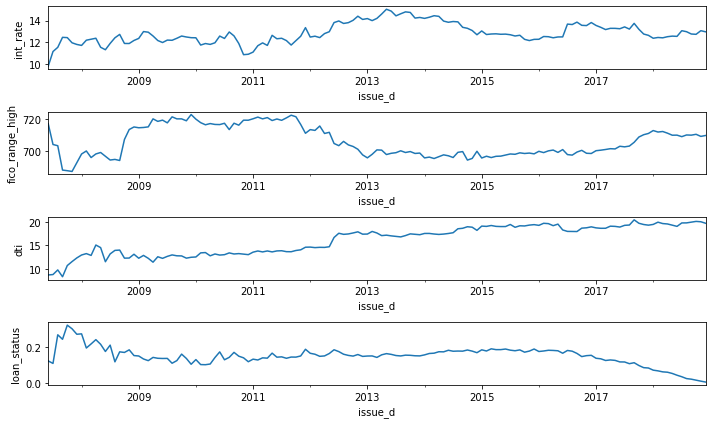

In [13]:
stats_over_time = df_sub.set_index("issue_d").groupby(pd.Grouper(freq="M"))[["int_rate","fico_range_high","dti","loan_status"]].mean()
fig, ax = plt.subplots(4,1,figsize=(10,6))
for i,col in enumerate(["int_rate","fico_range_high","dti","loan_status"]):
    plt.sca(ax[i])
    stats_over_time[col].plot()
    plt.ylabel(col)
    
plt.tight_layout()
plt.savefig("images/time_series.png")

We see all of the features change over time to some extent. The most notable pattern is that debt-to-income ratio has steadily increased from 10% to 20% over LendingClub's lifetime, indicating that the loans issued just before shutting down may be riskier. The decline in `loan_status` (which measures the fraction of loans which are bad) following 2016 is artificial -- rather it is a result of these loans not being complete. 

----

Back to explaining why NOT doing a temporally disjoint train-test split will lead to over-optimistic evaluation ⤵️ 

Suppose we do use an out-of-time test set. For example, use 3-year loans originating in 2010 for training, 3-year loans originating in 2014 for testing, and aim to predict default by the end of the loan term. Suppose then we build a naive model that predicts "default" if a borrower's credit score is below some threshold (say the 25th percentile in 2010, which is around 600) and "non-default" if their credit score is above 600. Now let's try to evaluate our model on the test set -- but suppose the 25th percentile credit score has rose to 650, but the relative amount of defaults has not changed. Many loans are going to be incorrectly classified as "non-default", leading to poorer -- but realistic -- performance.

Note: some practitioners try to account for time, but do it improperly. For example, I've seen people split their train, validation, and testing sets by origination date (say loans with dates up to the 70th percentile go to the training set, loans with dates between 70th and 85th percentile go to validation, and loans with dates greater than the 85th percentile go to testing). This fails to note the fact that some loans in the training set will not have finished before the first loan in the validation set, and similar for the validation and testing sets.

**We want temporally disjoint training and testing sets**.

Before we define our training/validation/testing datasets, we should note that there are two different loan terms (3 and 5 years). Three year loans are much more common, representing 71% of the data (see cell below). Because of this and because our dataset only consists of loans from 2007-2019 which we think is insufficient for making such long forecasts<sup>1</sup>, **we choose to focus on three year loans**.

&#8291;1. Constructing appopriate *out-of-time* training/validation/testing sets (read more about this in the next section) would require at least 15 years of data which we do not have (even if we used in-time validation, we would only be able to use loans originating in the first few months of the data to train on which would severely limit our data. Furthermore, making 5 year default predictions is incredibly hard -- generally it is better to improve upon short (1-2 year) forecasts rather than trying to make 5-10 year forecasts.

In [30]:
df_sub["term"].value_counts(normalize=True)

36.0    0.712138
60.0    0.287862
Name: term, dtype: float64

## Three ways to split
Including the "improper way", there are three different ways we could split the data. We provide visualizations of the time windows for each method.

In [31]:
# a helper function to conver a datetime to a float
# e.g. 2017-07-01 --> 2017.5
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

### 1. In-time testing
Randomly split data into training/validation/testing sets. By "in-time" testing, we mean that the model is evaluated on loans originating from the same time period as the training/validation data.

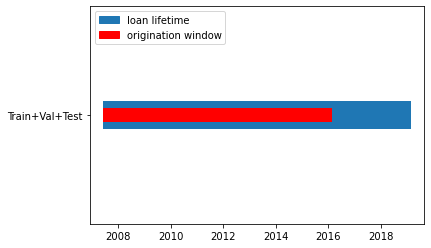

In [32]:
def add_legend(plt):
    handles, labels = plt.gca().get_legend_handles_labels()
    p1 = mpatches.Patch(color='C0', label='loan lifetime')
    p2 = mpatches.Patch(color='red', label='origination window')
    handles += [p1,p2]
    plt.legend(handles=handles, loc='upper left')
    
start, end = datetime2year(df_sub["issue_d"].min()), datetime2year(df_sub["last_pymnt_d"].max())
plt.barh(y=[0], width=[end-start], left=[start], height=0.25)
plt.barh(y=[0], width=[end-start-3], left=[start], height=0.125, color="red")
plt.yticks([0], ["Train+Val+Test"])
plt.xlim([start-0.5,end+0.5])
plt.ylim([-1,1])
add_legend(plt)

### 2. Out-of-time testing, in-time validation
Testing is done on future loans, but training and validation sets are randomly sampled from all loans **prior**. By prior we mean all loans ending before the the first origination date in the testing set.

Because we generally want more training data than validation/testing data, it makes sense to use a small origination window to specify loans in the out-of-time testing set. We choose to use one quarter (3 months) as the origination window for the testing data.

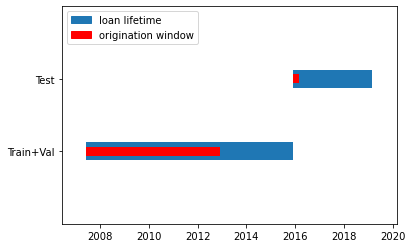

In [33]:
train_end = end-3.25
plt.barh(y=[0,1], width=[train_end-start,3.25], left=[start,train_end], height=0.25)
plt.barh(y=[0,1], width=[train_end-start-3,.25], left=[start,train_end], height=0.125, color="red")
plt.yticks([0,1], ["Train+Val", "Test"])
plt.xlim([start-1,end+1])
plt.ylim([-1,2])
add_legend(plt)

### 3. Out-of-time testing, out-of-time validation
Testing **and** validation are done on future loans.

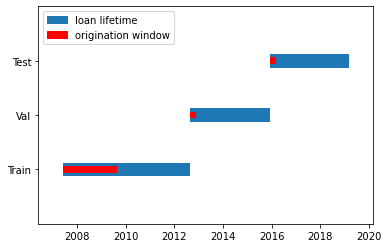

In [34]:
val_end = end-3.25
train_end = end-3.25*2
plt.barh(y=[0,1,2], width=[train_end-start,3.25,3.25], left=[start,val_end-3.25,val_end], height=0.25)
plt.barh(y=[0,1,2], width=[train_end-start-3,.25,.25], left=[start,val_end-3.25,val_end], height=0.125, color="red")
plt.yticks([0,1,2], ["Train", "Val", "Test"])
plt.xlim([start-1,end+1])
plt.ylim([-1,3])
add_legend(plt)

We will not use method 1 due to the reasons we discussed. When comparing method 2 and method 3, note that method 2 has the advantage of allowing for more training data, but the disadvantage is that our model may overfit to the training/validation data and perform poorly on the out-of-time testing data. We would hope that our model would learn to not rely heavily on features that change rapidly in time (i.e. we do not want a naive credit score cutoff model), but using in-time validation will not expose our model to unseen conditions. In some sense, method 3 may be able to regularize our model. At the same time, if the validation window is not like the training window, but the test window is similar to the training window (i.e. if credit score is higher in validation, but back down during testing) then this may harm the model. 

Another consideration is that LendingClub grew a lot over the time range of our dataset (see plot below). Very few loans were issued pre 2010 and, from an earlier plot showing loan status vs issue date, we saw that these loans were more likely to "go bad". This presents a major disadvantage of method 3.

<AxesSubplot:xlabel='issue_d'>

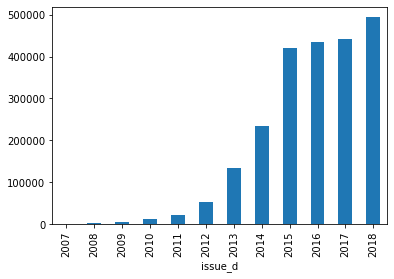

In [21]:
df_sub.groupby(df_sub["issue_d"].dt.year).count()["issue_d"].plot(kind="bar")

We'll choose method 2 because it offers us much more data. That is, for our testing set we will choose loans originating in 2016Q1. For our training & validation sets we will then find all three-year loans ending before 2016Q1 (so the last valid origination date should be 2012-12-31). From this, we'll then randomly sample 80-90% as training and the rest as validation. 

Note: we could instead use k-fold cross-validation (with k > 2); however, because we have a decent amount of data and because we will be applying a considerable amount of preprocessing & feature selection (which should be done separately on each training fold), resulting in increased computation time -- we will stick to 2-fold validation.

In [37]:
# testing: three-year loans originating in 2016Q1
test = df.loc[(df["issue_d"] >= datetime(2016,1,1)) & \
              (df["issue_d"] < datetime(2016,4,1)) & \
              (df["term"]==36) & \
              (df["loan_status"].isin(["Fully Paid", "Charged Off"]))]

print("Number of loans in testing set", test.shape[0])
test["loan_status"].value_counts()

Number of loans in testing set 89784


Fully Paid     75326
Charged Off    14458
Name: loan_status, dtype: int64

In [38]:
# training & validation: three-year loans originating prior to 2013
tr_val = df.loc[(df["issue_d"] < datetime(2012,12,31)) & \
                (df["term"]==36) & \
                (df["loan_status"].isin(["Fully Paid", "Charged Off"]))]

# random sample
idx = np.arange(len(tr_val))
np.random.shuffle(idx)
TR_SIZE = int(0.8*len(tr_val))
tr = tr_val.iloc[idx[:TR_SIZE],:]
val = tr_val.iloc[idx[TR_SIZE:],:]

print("Number of loans in training set", tr.shape[0])
print("Number of loans in validation set", val.shape[0])

Number of loans in training set 58052
Number of loans in validation set 14514


Our training/validation/testing sets combined contain around 150k loans, which is a lot but also a far smaller amount than the 2 million in the whole dataset.

In [39]:
# write to csv
tr.to_csv("train.csv", index = False)
val.to_csv("val.csv", index = False)
test.to_csv("test.csv", index = False)